# READ ME
This ipynb is for calculating the value function and ploting

"value_function_interpolation.json" use softmin, with 3 parameter for state

In [ ]:
import numpy as np
import json

# Ensure proper backend
# import matplotlib
# matplotlib.use('TkAgg')  # or 'Qt5Agg' depending on your environment


# Cost function parameters
w_d = 3.0  # Weight for distance cost Cd
w_theta = 1.0  # Weight for theta
w_theta_g = 2.0  # Weight for theta_g
k_d = 0.5
k_theta = 3.0  # Decay rate for theta importance
k_theta_g = 3.0  # Decay rate for theta_g importance
zeta = 1.0  # Constant cost

# Parameter for value function calculation
v_max = 0.3  # Max linear velocity
v_min = 0.0
number_of_linear_vel = 12  # Discretized linear velocities
omega_max = 1.6  # Max angular velocity
number_of_angle_vel = 12  # Discretized angular velocities
discount_factor = 0.99  # Discount factor
delta_t = 0.2  # Time step
max_distance = 2.0  # Furthest distance from goal
number_of_distance_point = 50
max_abs_angle_distance = np.pi  # Furthest angular distance
number_of_angle_point = 20
max_iterations = 10000  # Maximum iterations for value iteration
tolerance = 0.5  # Convergence threshold
max_steps = 1000  # Maximum steps for trajectory

# Discretize state space
d_values = np.linspace(0, max_distance, number_of_distance_point)  
theta_values = np.linspace(-max_abs_angle_distance, max_abs_angle_distance, number_of_angle_point)
theta_g_values = np.linspace(-max_abs_angle_distance, max_abs_angle_distance, number_of_angle_point)


v_values = np.linspace(v_min, v_max, number_of_linear_vel)  # Linear velocities
omega_values = np.linspace(-omega_max, omega_max, number_of_angle_vel)  # Angular velocities
v_values = np.append(v_values, 0)
omega_values = np.append(omega_values, 0)

# Initialize value function V(d, theta, theta_g)
V = np.zeros((len(d_values), len(theta_values), len(theta_g_values)))

# Cost function
def cost(d, theta, theta_g):
    # Define C_d
    D = min(d, max_distance)

    # Cost function with entangled weighting
    C_d = zeta if d > max_distance else (zeta * d) / max_distance
    return (w_d * D + w_theta * (1 - np.exp(-k_theta*D)) * abs(theta) + w_theta_g * np.exp(-k_theta_g * D) * abs(theta_g))

# Transition function
def transition(d, theta, theta_g, v, omega, d_values, theta_values, theta_g_values):
    # Convert (d, theta.to Cartesian coordinates
    x_t = d * np.cos(theta)
    y_t = d * np.sin(theta)

    # Apply transformation matrix
    cos_wt = np.cos(omega * delta_t)
    sin_wt = np.sin(omega * delta_t)

    x_next = cos_wt * x_t + sin_wt * y_t - cos_wt * v * delta_t
    y_next = -sin_wt * x_t + cos_wt * y_t + sin_wt * v * delta_t

    # Convert back to polar coordinates
    d_next = np.sqrt(x_next**2 + y_next**2)
    theta_next = np.arctan2(y_next, x_next)
    theta_g_next = theta_g - omega * delta_t  # Update goal orientation

    # Wrap angles to [-pi, pi]
    theta_next = (theta_next + np.pi) % (2 * np.pi) - np.pi
    theta_g_next = (theta_g_next + np.pi) % (2 * np.pi) - np.pi

    # Find nearest indices in discretized state space
    i_next = np.argmin(np.abs(d_values - d_next))
    j_next = np.argmin(np.abs(theta_values - theta_next))
    k_next = np.argmin(np.abs(theta_g_values - theta_g_next))
    
    return i_next, j_next, k_next

# Value Iteration with nearest neighbor transition
v_step = (v_max - v_min)/(number_of_linear_vel-1)
omega_step = (2*omega_max)/(number_of_angle_point- 1)
for iteration in range(max_iterations):
    delta = 0
    for i, d in enumerate(d_values):
        for j, theta in enumerate(theta_values):
            for k, theta_g in enumerate(theta_g_values):
                v_current = V[i, j, k]
                Q_values = []
                for v in v_values:
                    for omega in omega_values:
                        i_next, j_next, k_next = transition(d, theta, theta_g, v, omega, d_values, theta_values, theta_g_values)
                        Q_xu = cost(d, theta, theta_g) + discount_factor * V[i_next, j_next, k_next]
                        Q_values.append(Q_xu)
                
                # Update value function using softmin with log-sum-exp trick
                Q_values = np.array(Q_values)
                max_Q = np.max(Q_values)
                log_integral =  -max_Q + np.log(np.sum(np.exp(-Q_values + max_Q))) 
                V[i, j, k] = -log_integral
                # print(log_integral)
                delta = max(delta, abs(v_current - V[i, j, k]))
    
    print(f"Iteration {iteration + 1}: Max delta = {delta:.6f}")
    if delta < tolerance:
        print(f"Value iteration converged after {iteration + 1} iterations")
        break




KeyboardInterrupt: 

In [5]:
# Adding another term to cost function. The new term is the absolute value of the difference in gap orientation and goal heading 

import numpy as np
import json

# Ensure proper backend
# import matplotlib
# matplotlib.use('TkAgg')  # or 'Qt5Agg' depending on your environment


# Cost function parameters
w_d = 3.0  # Weight for distance cost Cd
w_theta = 1.0  # Weight for theta
w_theta_g1 = 2.0  # Weight for theta_g
w_theta_g2 = 2.0  # Weight for theta_g1
k_d = 0.5
k_theta = 0.5  # Decay rate for theta importance
k_theta_g1 = 2.0  # Decay rate for theta_g importance
k_theta_g2 = 4.0  # Decay rate for theta_g1 importance
zeta = 1.0  # Constant cost

# Parameter for value function calculation
v_max = 0.3  # Max linear velocity
v_min = 0.0
number_of_linear_vel = 14  # Discretized linear velocities
omega_max = 1.0  # Max angular velocity
number_of_angle_vel = 12  # Discretized angular velocities
discount_factor = 0.99  # Discount factor
delta_t = 0.2  # Time step
max_distance = 3.0  # Furthest distance from goal
number_of_distance_point = 50
max_abs_angle_distance = np.pi  # Furthest angular distance
number_of_angle_point = 20
max_iterations = 10000  # Maximum iterations for value iteration
tolerance = 0.05  # Convergence threshold
max_steps = 1000  # Maximum steps for trajectory

# Discretize state space
d_values = np.linspace(0, max_distance, number_of_distance_point)  
theta_values = np.linspace(-max_abs_angle_distance, max_abs_angle_distance, number_of_angle_point)
theta_g_values = np.linspace(-max_abs_angle_distance, max_abs_angle_distance, number_of_angle_point)


v_values = np.linspace(v_min, v_max, number_of_linear_vel)  # Linear velocities
omega_values = np.linspace(-omega_max, omega_max, number_of_angle_vel)  # Angular velocities
v_values = np.append(v_values, 0)
omega_values = np.append(omega_values, 0)

# Initialize value function V(d, theta, theta_g)
# V = np.zeros((len(d_values), len(theta_values), len(theta_g_values)))

# Cost function
def cost(d, theta, theta_g):
    # Define C_d
    D = min(d, max_distance)

    # Cost function with entangled weighting
    C_d = zeta if d > max_distance else (zeta * d) / max_distance
    return (w_d * D + 
            w_theta * (1 - np.exp(-k_theta*D)) * abs(theta) + 
            w_theta_g1 * np.exp(-k_theta_g1 * D) * (abs(theta_g)) + 
            w_theta_g2 * np.exp(-k_theta_g2 * D) * (abs(theta_g-theta)))

# Transition function
def transition(d, theta, theta_g, v, omega):
    # Convert (d, theta.to Cartesian coordinates
    x_t = d * np.cos(theta)
    y_t = d * np.sin(theta)

    # Apply transformation matrix
    cos_wt = np.cos(omega * delta_t)
    sin_wt = np.sin(omega * delta_t)

    x_next = cos_wt * x_t + sin_wt * y_t - cos_wt * np.cos(omega*delta_t/2)*v * delta_t + sin_wt * np.sin(omega*delta_t/2)*v * delta_t
    y_next = -sin_wt * x_t + cos_wt * y_t + sin_wt* np.cos(omega*delta_t/2)* v * delta_t  - cos_wt * np.sin(omega*delta_t/2)*v * delta_t


    # Convert back to polar coordinates
    d_next = np.sqrt(x_next**2 + y_next**2)
    theta_next = np.arctan2(y_next, x_next)
    theta_g_next = theta_g - omega * delta_t  # Update goal orientation

    # Wrap angles to [-pi, pi]
    theta_next = (theta_next + np.pi) % (2 * np.pi) - np.pi
    theta_g_next = (theta_g_next + np.pi) % (2 * np.pi) - np.pi
    
    return d_next, theta_next, theta_g_next

def value_of_state(d, theta, theta_g, d_values, theta_values, theta_g_values, V):
    # FIND VALUE OF CONTINUOUS STATE WITH TRINILEAR INTERPOLATION
    # Find the indices of the surrounding states in d, theta, and theta_g
    d_idx_low = np.searchsorted(d_values, d) - 1
    d_idx_high = d_idx_low + 1
    theta_idx_low = np.searchsorted(theta_values, theta) - 1
    theta_idx_high = theta_idx_low + 1
    theta_g_idx_low = np.searchsorted(theta_g_values, theta_g) - 1
    theta_g_idx_high = theta_g_idx_low + 1

    # Ensure the indices are within bounds
    d_idx_low = max(0, d_idx_low)
    d_idx_high = min(len(d_values) - 1, d_idx_high)
    theta_idx_low = max(0, theta_idx_low)
    theta_idx_high = min(len(theta_values) - 1, theta_idx_high)
    theta_g_idx_low = max(0, theta_g_idx_low)
    theta_g_idx_high = min(len(theta_g_values) - 1, theta_g_idx_high)

    # Retrieve the corner values for trilinear interpolation
    V000 = V[d_idx_low, theta_idx_low, theta_g_idx_low]
    V001 = V[d_idx_low, theta_idx_low, theta_g_idx_high]
    V010 = V[d_idx_low, theta_idx_high, theta_g_idx_low]
    V011 = V[d_idx_low, theta_idx_high, theta_g_idx_high]
    V100 = V[d_idx_high, theta_idx_low, theta_g_idx_low]
    V101 = V[d_idx_high, theta_idx_low, theta_g_idx_high]
    V110 = V[d_idx_high, theta_idx_high, theta_g_idx_low]
    V111 = V[d_idx_high, theta_idx_high, theta_g_idx_high]

   # Compute weights safely (avoid division by zero)
    def safe_weight(val, low, high):
        if high == low:
            return 0.0, 1.0  # All weight to the low (or high) value
        else:
            weight_low = (high - val) / (high - low)
            weight_high = (val - low) / (high - low)
            return weight_low, weight_high

    wd0, wd1 = safe_weight(d, d_values[d_idx_low], d_values[d_idx_high])
    wt0, wt1 = safe_weight(theta, theta_values[theta_idx_low], theta_values[theta_idx_high])
    wg0, wg1 = safe_weight(theta_g, theta_g_values[theta_g_idx_low], theta_g_values[theta_g_idx_high])

    # Interpolate
    c00 = V000 * wd0 + V100 * wd1
    c01 = V001 * wd0 + V101 * wd1
    c10 = V010 * wd0 + V110 * wd1
    c11 = V011 * wd0 + V111 * wd1

    c0 = c00 * wt0 + c10 * wt1
    c1 = c01 * wt0 + c11 * wt1

    value = c0 * wg0 + c1 * wg1
    return value


# Value Iteration with nearest neighbor transition
v_step = (v_max - v_min)/(number_of_linear_vel-1)
omega_step = (2*omega_max)/(number_of_angle_point- 1)
for iteration in range(max_iterations):
    delta = 0
    for i, d in enumerate(d_values):
        for j, theta in enumerate(theta_values):
            for k, theta_g in enumerate(theta_g_values):
                v_current = V[i, j, k]
                Q_values = []
                for v in v_values:
                    for omega in omega_values:
                        d_next, theta_next, theta_g_next = transition(d, theta, theta_g, v, omega)
                        next_value = value_of_state(d_next, theta_next, theta_g_next, d_values, theta_values, theta_g_values, V)
                        Q_xu = cost(d, theta, theta_g) + discount_factor * next_value
                        Q_values.append(Q_xu)
                
                # Update value function using softmin with log-sum-exp trick
                Q_values = np.array(Q_values)
                max_Q = np.max(Q_values)
                log_integral =  -max_Q + np.log(np.sum(np.exp(-Q_values + max_Q))) 
                V[i, j, k] = -log_integral
                # print(log_integral)
                delta = max(delta, abs(v_current - V[i, j, k]))
    
    print(f"Iteration {iteration + 1}: Max delta = {delta:.6f}")
    if delta < tolerance:
        print(f"Value iteration converged after {iteration + 1} iterations")
        break


KeyboardInterrupt: 

In [15]:
# Use softmax instead of softmin

import numpy as np
import json

# Ensure proper backend
# import matplotlib
# matplotlib.use('TkAgg')  # or 'Qt5Agg' depending on your environment


# Cost function parameters
w_d = 0.0  # Weight for distance cost Cd
w_theta = 1.0  # Weight for theta
w_theta_g = 0.0  # Weight for theta_g
k_d = 0.5
k_theta = 3.0  # Decay rate for theta importance
k_theta_g = 3.0  # Decay rate for theta_g importance
zeta = 1.0  # Constant cost
d_threshold = 2.0  # Distance cap

# Parameter for value function calculation
v_max = 2.0  # Max linear velocity
v_min = 0.0
number_of_linear_vel = 12  # Discretized linear velocities
omega_max = 3.2  # Max angular velocity
number_of_angle_vel = 12  # Discretized angular velocities
discount_factor = 0.0  # Discount factor
delta_t = 0.1  # Time step
max_distance = 2.0  # Furthest distance from goal
number_of_distance_point = 30
max_abs_angle_distance = np.pi  # Furthest angular distance
number_of_angle_point = 20
max_iterations = 10000  # Maximum iterations for value iteration
tolerance = 0.5  # Convergence threshold
max_steps = 1000  # Maximum steps for trajectory

# Discretize state space
d_values = np.linspace(0, max_distance, number_of_distance_point)  
theta_values = np.linspace(-max_abs_angle_distance, max_abs_angle_distance, number_of_angle_point)
theta_g_values = np.linspace(-max_abs_angle_distance, max_abs_angle_distance, number_of_angle_point)


v_values = np.linspace(v_min, v_max, number_of_linear_vel)  # Linear velocities
omega_values = np.linspace(-omega_max, omega_max, number_of_angle_vel)  # Angular velocities
v_values = np.append(v_values, 0)
omega_values = np.append(omega_values, 0)

# Initialize value function V(d, theta, theta_g)
V = np.zeros((len(d_values), len(theta_values), len(theta_g_values)))

# Cost function
def cost(d, theta, theta_g):
    # Define C_d
    D = min(d, d_threshold)

    # Cost function with entangled weighting
    C_d = zeta if d > d_threshold else (zeta * d) / d_threshold
    return - (w_d * D + w_theta * (1 - np.exp(-k_theta*D)) * abs(theta) + w_theta_g * np.exp(-k_theta_g * D) * abs(theta_g))

# Transition function
def transition(d, theta, theta_g, v, omega, d_values, theta_values, theta_g_values):
    # Convert (d, theta.to Cartesian coordinates
    x_t = d * np.cos(theta)
    y_t = d * np.sin(theta)

    # Apply transformation matrix
    cos_wt = np.cos(omega * delta_t)
    sin_wt = np.sin(omega * delta_t)

    x_next = cos_wt * x_t + sin_wt * y_t - cos_wt * v * delta_t
    y_next = -sin_wt * x_t + cos_wt * y_t + sin_wt * v * delta_t

    # Convert back to polar coordinates
    d_next = np.sqrt(x_next**2 + y_next**2)
    theta_next = np.arctan2(y_next, x_next)
    theta_g_next = theta_g - omega * delta_t  # Update goal orientation

    # Wrap angles to [-pi, pi]
    theta_next = (theta_next + np.pi) % (2 * np.pi) - np.pi
    theta_g_next = (theta_g_next + np.pi) % (2 * np.pi) - np.pi

    # Find nearest indices in discretized state space
    i_next = np.argmin(np.abs(d_values - d_next))
    j_next = np.argmin(np.abs(theta_values - theta_next))
    k_next = np.argmin(np.abs(theta_g_values - theta_g_next))
    
    return i_next, j_next, k_next

# Value Iteration with nearest neighbor transition
for iteration in range(max_iterations):
    delta = 0
    for i, d in enumerate(d_values):
        for j, theta in enumerate(theta_values):
            for k, theta_g in enumerate(theta_g_values):
                v_current = V[i, j, k]
                Q_values = []

                for v in v_values:
                    for omega in omega_values:
                        i_next, j_next, k_next = transition(d, theta, theta_g, v, omega, d_values, theta_values, theta_g_values)
                        Q_xu = cost(d, theta, theta_g) + discount_factor * V[i_next, j_next, k_next]
                        Q_values.append(Q_xu)
                
                # Update value function using softmin with log-sum-exp trick
                Q_values = np.array(Q_values)
                max_Q = np.max(Q_values)
                log_integral = max_Q + np.log(np.sum(np.exp(Q_values - max_Q)))
                V[i, j, k] = log_integral
                
                delta = max(delta, abs(v_current - V[i, j, k]))
    
    print(f"Iteration {iteration + 1}: Max delta = {delta:.6f}")
    if delta < tolerance:
        print(f"Value iteration converged after {iteration + 1} iterations")
        break


Iteration 1: Max delta = 5.129899
Iteration 2: Max delta = 0.000000
Value iteration converged after 2 iterations


In [24]:
import numpy as np
print(np.linspace(-1,1,4))

[-1.         -0.33333333  0.33333333  1.        ]


In [4]:
# Read from json file
import json
import numpy as np

# Path to the JSON file
saving_path = "../data/value_function_interpolation.json"

# Load the JSON file
try:
    with open(saving_path, "r") as f:
        data = json.load(f)

    # Extract metadata
    discount_factor = data["metadata"]["discount_factor"]
    delta_t = data["metadata"]["delta_t"]
    max_distance = data["metadata"]["max_distance"]
    number_of_distance_point = data["metadata"]["number_of_distance_point"]
    max_abs_angle_distance = data["metadata"]["max_abs_angle_distance"]
    number_of_angle_point = data["metadata"]["number_of_angle_point"]

    # Extract cost function parameters
    w_theta = data["cost_function_param"]["w_theta"]
    w_d = data["cost_function_param"]["w_d"]
    w_theta_g = data["cost_function_param"]["w_theta_g"]
    d_threshold = data["cost_function_param"]["distance_threshold"]
    k_theta = data["cost_function_param"]["k_theta"]
    k_d = data["cost_function_param"]["k_d"]
    k_theta_g = data["cost_function_param"]["k_theta_g"]

    # Convert matrix back to a NumPy array
    V = np.array(data["matrix"])

    # Print confirmation
    print("Data successfully loaded from JSON.")
    print(f"Discount Factor: {discount_factor}")
    print(f"Matrix shape: {V.shape}")  # Checking dimensions

except FileNotFoundError:
    print(f"Error: File '{saving_path}' not found.")
except json.JSONDecodeError:
    print(f"Error: File '{saving_path}' is not a valid JSON file.")


Data successfully loaded from JSON.
Discount Factor: 0.99
Matrix shape: (50, 20, 20)


In [30]:
# Initialize trajectory from the given starting state 
d_init, theta_init, theta_g_init = 2.0, 1.6, 1.6 # Starting state

# i_init = np.argmin(np.abs(d_values - d_init))
# j_init = np.argmin(np.abs(theta_values - theta_init))
# k_init = np.argmin(np.abs(theta_g_values - theta_g_init))

# Initialize trajectory lists
d_traj = [d_init]
theta_traj = [theta_init]
theta_g_traj = [theta_g_init]

# Start iteration
# i, j, k = i_init, j_init, k_init
d, theta, theta_g = d_init, theta_init, theta_g_init
step = 0  # Step counter
max_steps = 100  # Define a max step to prevent infinite loop

while not (d_traj[-1] <= 1e-6 and abs(theta_g_traj[-1]) <= 1e-6) and step < max_steps:
    min_value = np.inf
    best_v, best_omega = 0, 0
    best_d, best_theta, best_theta_g = d, theta, theta_g  # Default to current state
    print(f"Step {step}:")
    # Find the optimal action (v, omega)
    for v in v_values:
        for omega in omega_values:
            # Find the true next state using the transition function
            d_next, theta_next, theta_g_next = transition(d, theta, theta_g, v, omega)
            
            # Use trilinear interpolation to get the value of the next state
            next_value = value_of_state(d_next, theta_next, theta_g_next, d_values, theta_values, theta_g_values, V)

            # Calculate cost
            value = cost(d, theta, theta_g) + discount_factor * next_value
            
            print(f"Possible next state (d={d_next:.4f}, θ={theta_next:.4f}, θ_g={theta_g_next:.4f}) with value={value} when velocity = {v} and yaw rate = {omega}")
            if value <=  min_value:
                min_value = value
                best_v, best_omega = v, omega
                best_d, best_theta, best_theta_g = d_next, theta_next, theta_g_next

    # Print current and next state information
    print(f"  Current State: (d={d:.4f}, θ={theta:.4f}, θ_g={theta_g:.4f})")
    print(f"  Next State: (d={best_d:.4f}, θ={best_theta:.4f}, θ_g={best_theta_g:.4f})")

    # Append the best action to the trajectory
    d_traj.append(best_d)
    theta_traj.append(best_theta)
    theta_g_traj.append(best_theta_g)

    # Check if the best next state is the same as the current state
    if (best_d == d and best_theta == theta and best_theta_g == theta_g):
        print("  ⚠ No better state found, stopping trajectory generation.")
        break

    # Update current state to the next state
    d, theta, theta_g = best_d, best_theta, best_theta_g
    step += 1

# Indicate trajectory generation has finished
print("\n✅ Trajectory generation complete.")


Step 0:
Possible next state (d=2.0000, θ=1.8000, θ_g=1.8000) with value=-159.14701721873908 when velocity = 0.0 and yaw rate = -1.0
Possible next state (d=2.0000, θ=1.7636, θ_g=1.7636) with value=-160.1838560353512 when velocity = 0.0 and yaw rate = -0.8181818181818181
Possible next state (d=2.0000, θ=1.7273, θ_g=1.7273) with value=-161.26721880864469 when velocity = 0.0 and yaw rate = -0.6363636363636364
Possible next state (d=2.0000, θ=1.6909, θ_g=1.6909) with value=-162.39710553861957 when velocity = 0.0 and yaw rate = -0.4545454545454546
Possible next state (d=2.0000, θ=1.6545, θ_g=1.6545) with value=-163.57351622527585 when velocity = 0.0 and yaw rate = -0.2727272727272727
Possible next state (d=2.0000, θ=1.6182, θ_g=1.6182) with value=-164.7964508686135 when velocity = 0.0 and yaw rate = -0.09090909090909083
Possible next state (d=2.0000, θ=1.5818, θ_g=1.5818) with value=-166.0659094686325 when velocity = 0.0 and yaw rate = 0.09090909090909083
Possible next state (d=2.0000, θ=1.5

Trajectory: [2.0, 1.9999999999999998, 1.987705780653011, 1.963691784002693, 1.9309430705929598, 1.8903508183289865, 1.8430747647897436, 1.7905509826669153, 1.7339759750993282, 1.6748109789922798, 1.6155945390962467, 1.5563673984461108, 1.4970919216028673, 1.4378765470342774, 1.3796918563618703, 1.3214526049425044, 1.2622723366375435, 1.2030989607210751, 1.1438965865312913, 1.0847081631638602, 1.0254988292294311, 0.9663128858846629, 0.9070475906268107, 0.8477731721262224, 0.7885366875419614, 0.7293088654607596, 0.670141953384333, 0.6109395742733593, 0.5517130321301803, 0.49247672014701227, 0.4332502286557096, 0.37406244982135284, 0.3149602875088915, 0.2559727223804939, 0.1984850813898531, 0.13917990151733553, 0.08458016052294708, 0.07547865963912659, 0.07547865963912659]
Theta: [1.6, 1.4000000000000004, 1.223668728920595, 1.050187679513603, 0.8745424840114726, 0.6959564981136079, 0.5136156417250746, 0.32667406784782616, 0.17127647163608284, 0.15887772859447935, 0.1647533765765261, 0.152

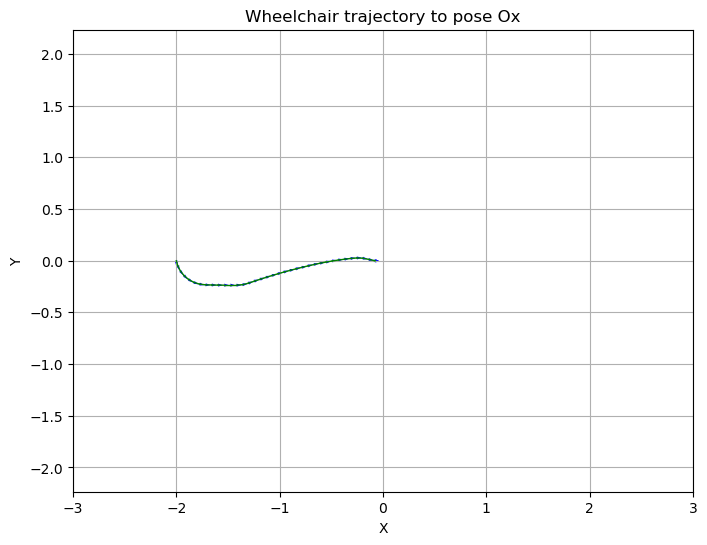

In [31]:
## Visualize the best trajectory of wheelchair
print(f"Trajectory: {d_traj}")
print(f"Theta: {theta_traj}")   
print(f"Theta_g: {theta_g_traj}")

import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 6))
prev_x_pos, prev_y_pos = 0, 0  # Start with origin (0, 0)

# Loop over the values in the lists and plot each vector
for d, theta, theta_g in zip(d_traj, theta_traj, theta_g_traj):
    # Calculate the position of the vector
    x_pos = -np.cos(theta_g) *d*np.cos(theta) - np.sin(theta_g)*d*np.sin(theta) # x-component of the position
    y_pos = np.sin(theta_g)*d*np.cos(theta) - np.cos(theta_g)*d*np.sin(theta)  # y-component of the position

    # The orientation of the vector is -theta_g
    # The direction of the arrow (dx, dy) based on -theta_g
    dx = np.cos(-theta_g)
    dy = np.sin(-theta_g)

    # Normalize the direction vector to have a unit length
    norm = np.sqrt(dx**2 + dy**2)
    dx /= norm
    dy /= norm

    # Scale the direction vector by the desired length (0.1)
    dx *= 0.05
    dy *= 0.05

    # Plot the vector as an arrow from the position (x_pos, y_pos) to (x_pos + dx, y_pos + dy)
    plt.quiver(x_pos, y_pos,  dx, dy, angles='xy', scale_units='xy', scale=1, color='b')
    # Plot a line connecting the current vector's origin to the previous one
    if prev_x_pos != 0 or prev_y_pos != 0:  # Skip this step for the very first point
        plt.plot([prev_x_pos, x_pos], [prev_y_pos, y_pos], color='g', linestyle='-', linewidth=1)

    # Update the previous position for the next loop
    prev_x_pos, prev_y_pos = x_pos, y_pos

# Label the axes and the plot
plt.title('Wheelchair trajectory to pose Ox')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Set equal scaling on both axes to ensure proportional arrow lengths and directions
plt.axis('equal')

# Set axis limits for x and y
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Show the plot
plt.savefig("optimal_path3.png")
plt.show()

In [7]:
#Use softmax instead

# Initialize trajectory from the given starting state 
d_init, theta_init, theta_g_init = 1.0, 0.0, 0.0  # Starting state
i_init = np.argmin(np.abs(d_values - d_init))
j_init = np.argmin(np.abs(theta_values - theta_init))
k_init = np.argmin(np.abs(theta_g_values - theta_g_init))

# Initialize trajectory lists
d_traj = [d_init]
theta_traj = [theta_init]
theta_g_traj = [theta_g_init]

# Start iteration
i, j, k = i_init, j_init, k_init
step = 0  # Step counter
max_steps = 50  # Define a max step to prevent infinite loop

while not (d_traj[-1] <= 1e-6 and abs(theta_g_traj[-1]) <= 1e-6) and step < max_steps:
    max_value = -np.inf
    best_v, best_omega = 0, 0
    best_i, best_j, best_k = i, j, k  # Default to current state

    print(f"Step {step}:")
    # Find the optimal action (v, omega)
    for v in v_values:
        for omega in omega_values:
            i_next, j_next, k_next = transition(d_values[i], theta_values[j], theta_g_values[k], v, omega, d_values, theta_values, theta_g_values)
            value = cost(d_values[i], theta_values[j], theta_g_values[k]) + discount_factor * V[i_next, j_next, k_next]
            print(f"Possible next state index (i={i_next}, j={j_next}, theta = {theta_values[j_next]}, k={k_next}, theta_g = {theta_g_values[k_next]}) with value={value} when velocity = {v} and yaw rate = {omega}")
            if value > max_value:
                max_value = value
                best_v, best_omega = v, omega
                best_i, best_j, best_k = i_next, j_next, k_next

    # Print current and next state information
    print(f"  Current State Index: (i={i}, j={j}, k={k}) -> (d={d_values[i]:.4f}, θ={theta_values[j]:.4f}, θ_g={theta_g_values[k]:.4f})")
    print(f"  Next State Index: (i={best_i}, j={best_j}, k={best_k}) -> (d={d_values[best_i]:.4f}, θ={theta_values[best_j]:.4f}, θ_g={theta_g_values[best_k]:.4f})")

    # Check if the best next state is the same as the current state
    if (best_i == i and best_j == j and best_k == k):
        print("  ⚠ No better state found, stopping trajectory generation.")
        break

    # Append the new state to the trajectory
    d_traj.append(d_values[best_i])
    theta_traj.append(theta_values[best_j])
    theta_g_traj.append(theta_g_values[best_k])

    # Update the indices
    i, j, k = best_i, best_j, best_k
    step += 1  # Increment step counter

# Indicate trajectory generation has finished
print("\n✅ Trajectory generation complete.")

Step 0:
Possible next state index (i=16, j=10, theta = 0.16534698176788387, k=10, theta_g = 0.16534698176788387) with value=-323.68311424710015 when velocity = 0.0 and yaw rate = -1.6
Possible next state index (i=16, j=10, theta = 0.16534698176788387, k=10, theta_g = 0.16534698176788387) with value=-323.68311424710015 when velocity = 0.0 and yaw rate = -1.309090909090909
Possible next state index (i=16, j=10, theta = 0.16534698176788387, k=10, theta_g = 0.16534698176788387) with value=-323.68311424710015 when velocity = 0.0 and yaw rate = -1.018181818181818
Possible next state index (i=16, j=9, theta = -0.16534698176788387, k=9, theta_g = -0.16534698176788387) with value=-323.6638629296044 when velocity = 0.0 and yaw rate = -0.7272727272727273
Possible next state index (i=16, j=9, theta = -0.16534698176788387, k=9, theta_g = -0.16534698176788387) with value=-323.6638629296044 when velocity = 0.0 and yaw rate = -0.4363636363636363
Possible next state index (i=16, j=9, theta = -0.1653469

In [118]:
import plotly.graph_objects as go


d_init, theta_init, theta_g_init = 2.0, 3.0, 3.0  # Starting state
i_init = np.argmin(np.abs(d_values - d_init))
j_init = np.argmin(np.abs(theta_values - theta_init))
k_init = np.argmin(np.abs(theta_g_values - theta_g_init))

# Initialize trajectory lists
d_traj = [d_init]
theta_traj = [theta_init]
theta_g_traj = [theta_g_init]

# Start iteration
i, j, k = i_init, j_init, k_init
step = 0  # Step counter

while not (d_traj[-1] <= 1e-6 and abs(theta_g_traj[-1]) <= 1e-6) and step < max_steps:
    min_value = np.inf
    best_v, best_omega = 0, 0

    # Find the optimal action (v, omega)
    for v in v_values:
        for omega in omega_values:
            i_next, j_next, k_next = transition(d_values[i], theta_values[j], theta_g_values[k], v, omega, d_values, theta_values, theta_g_values)
            value = cost(d_values[i], theta_values[j], theta_g_values[k]) + discount_factor * V[i_next, j_next, k_next]

            if value < min_value:
                min_value = value
                best_v, best_omega = v, omega

    # Apply the optimal action to get the next state
    i_next, j_next, k_next = transition(d_values[i], theta_values[j], theta_g_values[k], best_v, best_omega, d_values, theta_values, theta_g_values)

    # Append the new state to the trajectory
    d_traj.append(d_values[i_next])
    theta_traj.append(theta_values[j_next])
    theta_g_traj.append(theta_g_values[k_next])

    # Update the indices
    i, j, k = i_next, j_next, k_next
    step += 1  # Increment step counter


TypeError: transition() takes 5 positional arguments but 8 were given

In [6]:
import plotly.graph_objects as go

# Flatten the arrays for Plotly volume rendering
X_flat, Y_flat, Z_flat = np.meshgrid(d_values, theta_values, theta_g_values, indexing="ij")
X_flat, Y_flat, Z_flat, V_flat = X_flat.flatten(), Y_flat.flatten(), Z_flat.flatten(), V.flatten()

# Create an interactive 3D volume plot
fig = go.Figure()

# Add volume rendering of the value function
fig.add_trace(go.Volume(
    x=X_flat, y=Y_flat, z=Z_flat, value=V_flat,
    opacity=0.3, surface_count=15, colorscale="RdBu",
    name="Value Function"
))

# Add trajectory using arrows (quiver-like effect)
for t in range(len(d_traj) - 1):
    fig.add_trace(go.Scatter3d(
        x=[d_traj[t], d_traj[t + 1]],
        y=[theta_traj[t], theta_traj[t + 1]],
        z=[theta_g_traj[t], theta_g_traj[t + 1]],
        mode="lines+markers",
        marker=dict(size=4, color='black'),
        line=dict(width=4, color='black'),
        name=f"Step {t} to {t+1}"
    ))

# Configure layout
fig.update_layout(
    title="3D Volume Rendering of Value Function with Trajectory",
    scene=dict(
        xaxis_title="Distance to goal (m)",
        yaxis_title="Orientation (rad)",
        zaxis_title="Gap Orientation (rad)"
    )
)

# Show interactive 3D plot
fig.show(renderer="browser")


In [63]:
import plotly.graph_objects as go
# Flatten the arrays for Plotly volume rendering
X_flat, Y_flat, Z_flat = np.meshgrid(d_values, theta_values, theta_g_values, indexing="ij")
X_flat, Y_flat, Z_flat, V_flat = X_flat.flatten(), Y_flat.flatten(), Z_flat.flatten(), V.flatten()

fig = go.Figure()

fig.add_trace(go.Volume(
    x=X_flat, y=Y_flat, z=Z_flat, value=V_flat,
    opacity=0.1, surface_count=15, colorscale="RdBu",
    name="Value Function"
))

# Add the optimal trajectory inside the volume
fig.add_trace(go.Scatter3d(
    x=d_traj, y=theta_traj, z=theta_g_traj,
    mode="lines+markers",
    marker=dict(size=5, color=np.linspace(0, 1, len(d_traj)), colorscale="Viridis"),
    line=dict(width=4, color="black"),
    name="Optimal Trajectory"
))

# Configure layout
fig.update_layout(
    title="3D Value Function Volume with Optimal Trajectory",
    scene=dict(
        xaxis_title="Distance (d)",
        yaxis_title="Orientation (theta)",
        zaxis_title="Gap Orientation (theta_g)"
    )
)

# Show interactive 3D plot
fig.show(renderer="browser")

In [97]:
import json


# Save to file path
saving_path = "../data/value_function_interpolation3.json"

# Save value function to Json file
metadata = {
    "discount_factor" : discount_factor,  # discount factor
    "delta_t" : delta_t,  # time step
    "max_distance" : max_distance,  #furthest distance from goal to be considered
    "number_of_distance_point" : number_of_distance_point,
    "max_abs_angle_distance" : max_abs_angle_distance, #furthest angular distance to be considered (in both direction) 
    "number_of_angle_point" : number_of_angle_point,
    "number_of_angle_vel" : number_of_angle_vel,
    "number_of_linear_vel" : number_of_linear_vel,
}
cost_function_param ={
    "w_theta" : w_theta,
    "w_d" : w_d,
    "w_theta_g" : w_theta_g,
    "distance_threshold" : d_threshold,  # beyond which the cost for distance do not change
    "k_theta" : k_theta,
    "k_d" : k_d,
    "k_theta_g" : k_theta_g
}
data = {
    "cost_function_param" : cost_function_param,
    "metadata": metadata,
    "matrix": V.tolist()
}
with open(saving_path, "w") as f:
    json.dump(data, f, indent=4)  # Pretty-print with indentation
print(f"Saved to {saving_path}")

Saved to ../data/value_function_interpolation3.json


In [18]:
print(np.exp(-2))

0.1353352832366127
